<a href="https://colab.research.google.com/github/MpRonald/Machine-Learning/blob/main/Decision_Tree_Regressor_Flight_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

In [69]:
# reading data from github
data_train = pd.read_excel("/content/drive/MyDrive/Datasets/Flight_Train.xlsx")
data_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [70]:
# reading data from github
data_test = pd.read_excel("/content/drive/MyDrive/Datasets/Flight_Test.xlsx")
data_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [71]:
# concatenar data frames
data = pd.concat([data_test, data_train], sort=False)
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,NaN
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,NaN
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,NaN
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,NaN
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,NaN


In [72]:
data.shape

(13354, 11)

In [73]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [74]:
data.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
dtype: int64

In [75]:
data.dropna(inplace=True)

In [76]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [77]:
data.duplicated().sum()

220

In [78]:
data[data.duplicated()].head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376.0
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231.0
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392.0
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368.0
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303.0


In [79]:
# delete duplicated values
data.drop_duplicates(keep='first', inplace=True)

In [80]:
data.duplicated().sum()

0

In [81]:
# checking frequence table
data["Additional_Info"].value_counts()

No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [82]:
# checking airlines names 
data.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

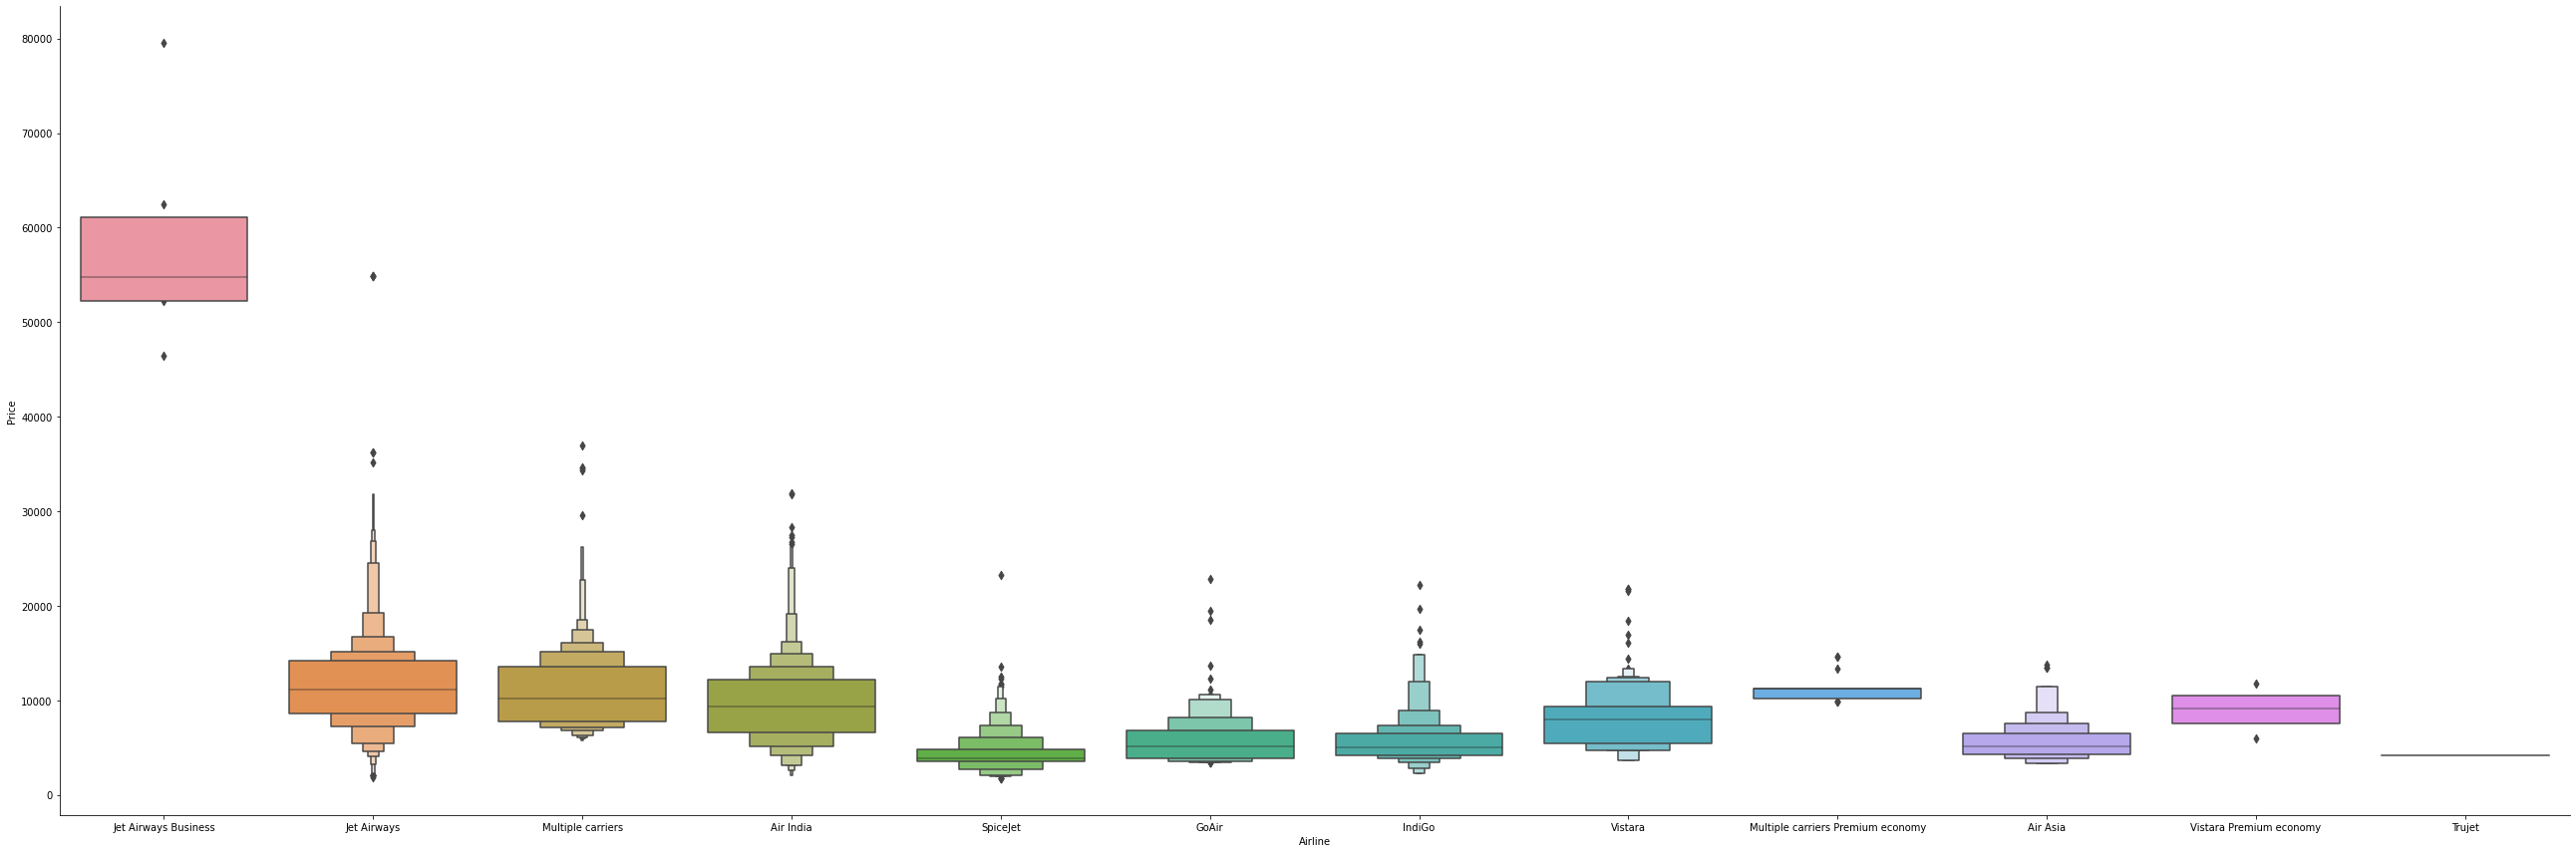

In [83]:
# Plotting Price vs Airline
sns.catplot(y = "Price", x = "Airline", data = data.sort_values("Price", ascending = False),
            kind = "boxen", height=12, aspect = 3);

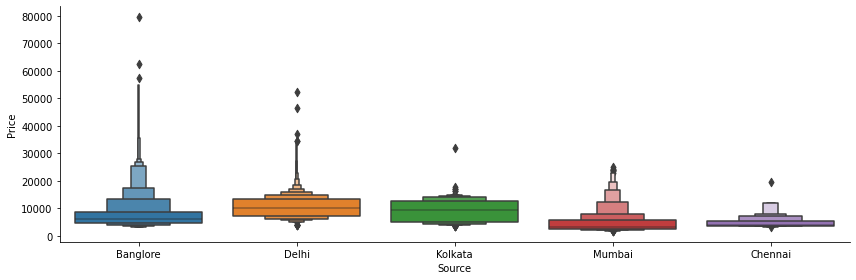

In [84]:
sns.catplot(y = "Price", x = "Source", data = data.sort_values("Price", ascending = False),
            kind = "boxen", height=4, aspect = 3);

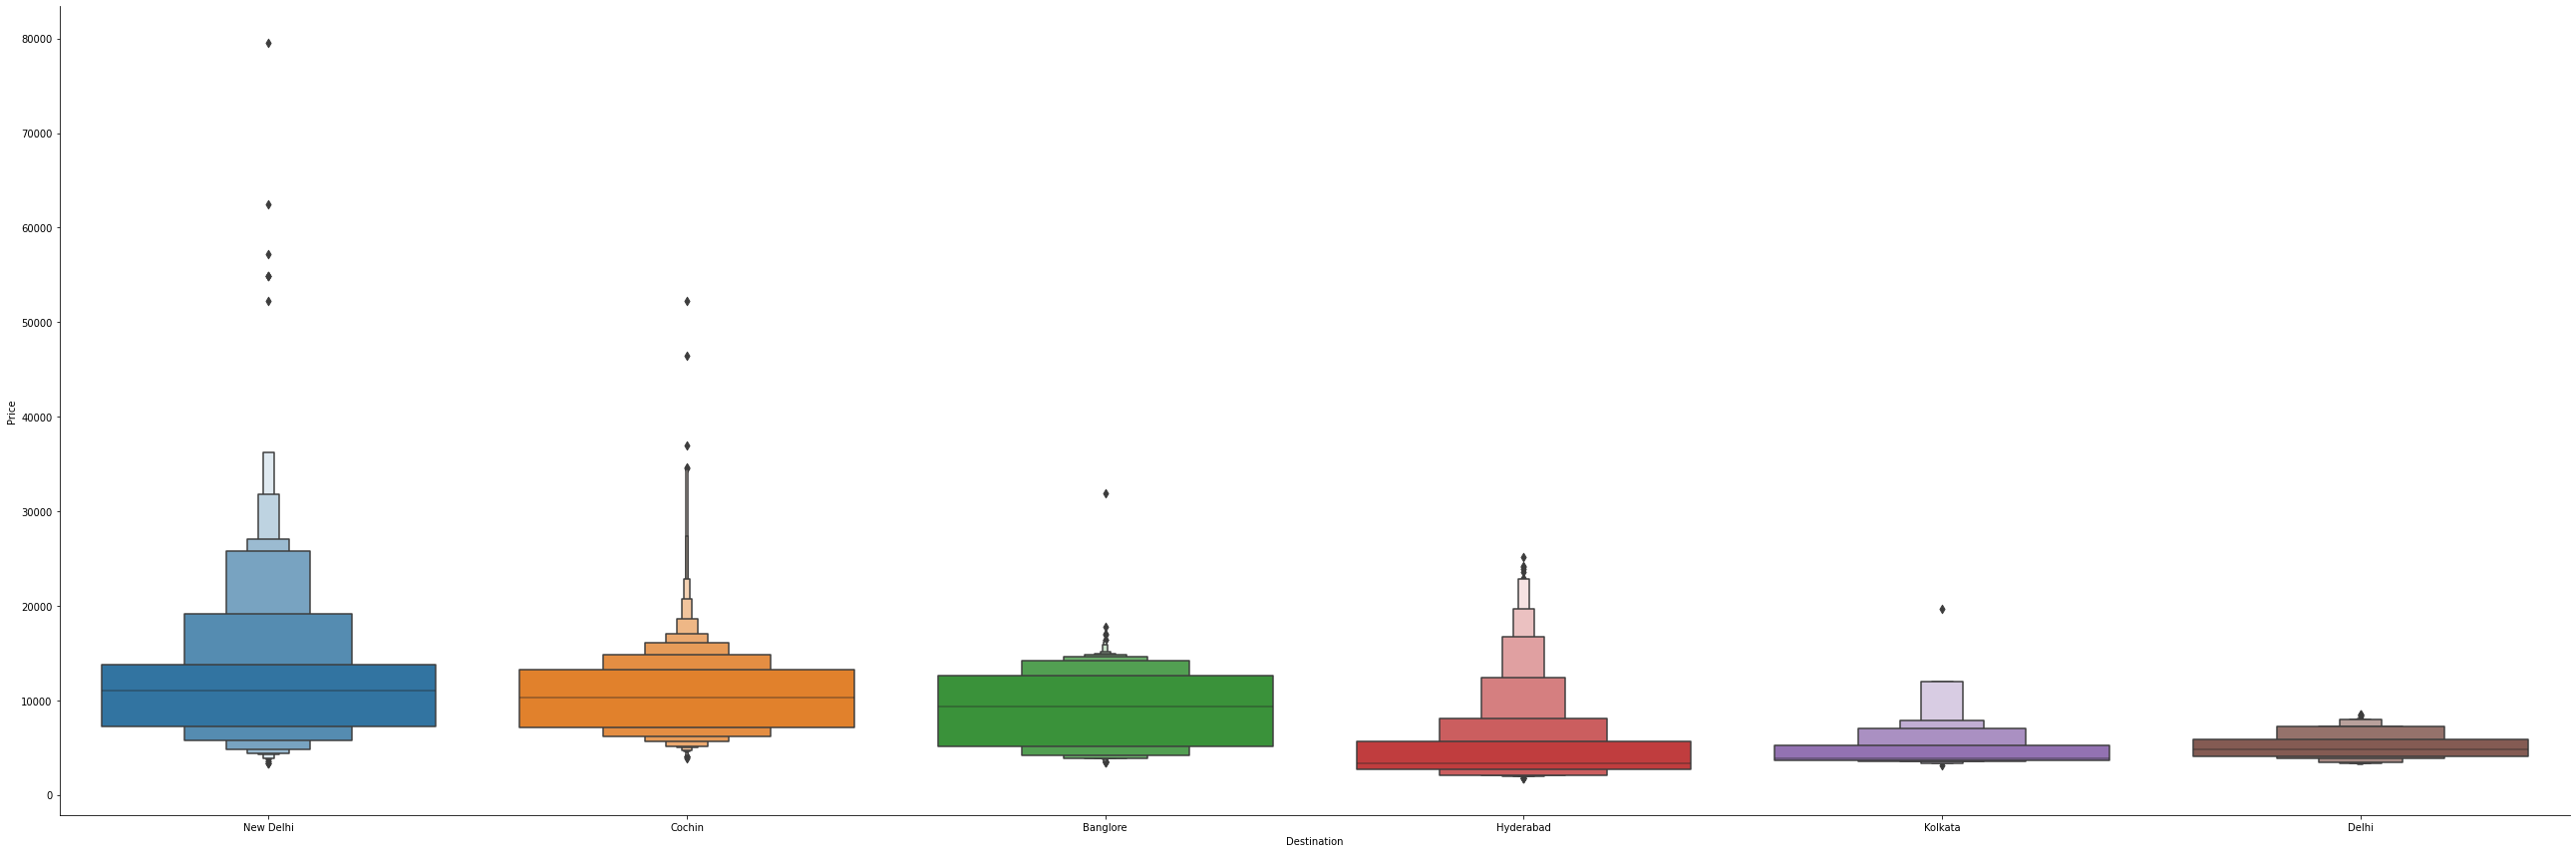

In [85]:
sns.catplot(y = "Price", x = "Destination", data = data.sort_values("Price", ascending = False),
            kind = "boxen", height=12, aspect = 3);

In [86]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


In [87]:
# Duration
data['Duration'] = data['Duration'].str.replace("h", '*60').str.replace(" ",'+').str.replace("m",'*1').apply(eval)

# Date_of_Journey
data['Journey_day'] = data['Date_of_Journey'].str.split('/').str[0].astype(int)
data['Journey_month'] = data['Date_of_Journey'].str.split('/').str[0].astype(int)
data.drop(['Date_of_Journey'], axis=1, inplace=True)

# Dep_Time
data['Dep_hour'] = pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_min'] = pd.to_datetime(data['Dep_Time']).dt.minute
data.drop(['Dep_Time'], axis=1, inplace=True)

data['Arrival_hour'] = pd.to_datetime(data['Arrival_Time']).dt.hour
data['Arrival_min'] = pd.to_datetime(data['Arrival_Time']).dt.minute
data.drop(['Arrival_Time'], axis=1, inplace=True)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10462 non-null  object 
 1   Source           10462 non-null  object 
 2   Destination      10462 non-null  object 
 3   Route            10462 non-null  object 
 4   Duration         10462 non-null  int64  
 5   Total_Stops      10462 non-null  object 
 6   Additional_Info  10462 non-null  object 
 7   Price            10462 non-null  float64
 8   Journey_day      10462 non-null  int64  
 9   Journey_month    10462 non-null  int64  
 10  Dep_hour         10462 non-null  int64  
 11  Dep_min          10462 non-null  int64  
 12  Arrival_hour     10462 non-null  int64  
 13  Arrival_min      10462 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 1.2+ MB


Text(0, 0.5, 'Numbers of Flights')

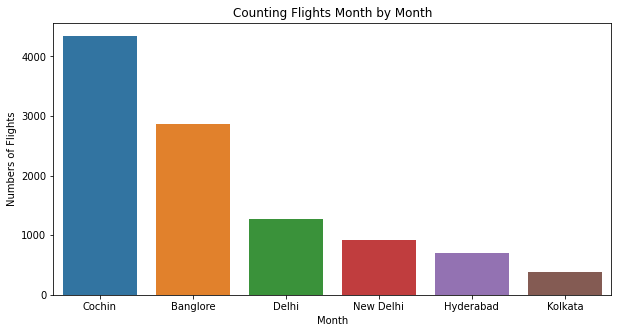

In [89]:
from pandas.core.groupby import groupby
# Plotting Bar chart for Months (Duration) vs Number of Flights
plt.figure(figsize=(10,5))
plt.title("Counting Flights Month by Month")
ax = sns.countplot(x = 'Destination', data=data, order=data['Destination'].value_counts().index)
plt.xlabel("Month")
plt.ylabel("Numbers of Flights")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

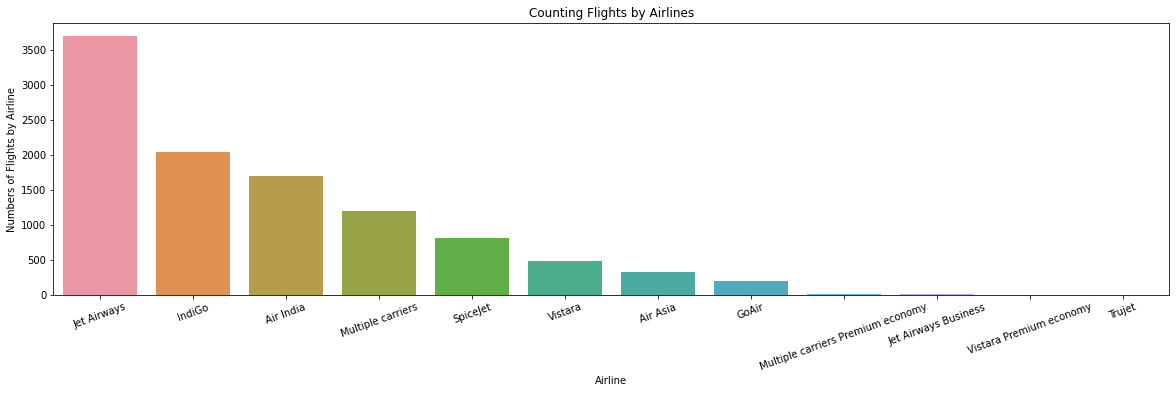

In [90]:
from pandas.core.groupby import groupby
# Plotting Bar chart for Months (Duration) vs Number of Flights
plt.figure(figsize=(20,5))
plt.title("Counting Flights by Airlines")
ax = sns.countplot(x = 'Airline', data=data, order=data['Airline'].value_counts().index)
plt.xlabel("Airline")
plt.ylabel("Numbers of Flights by Airline")
plt.xticks(rotation = 20)

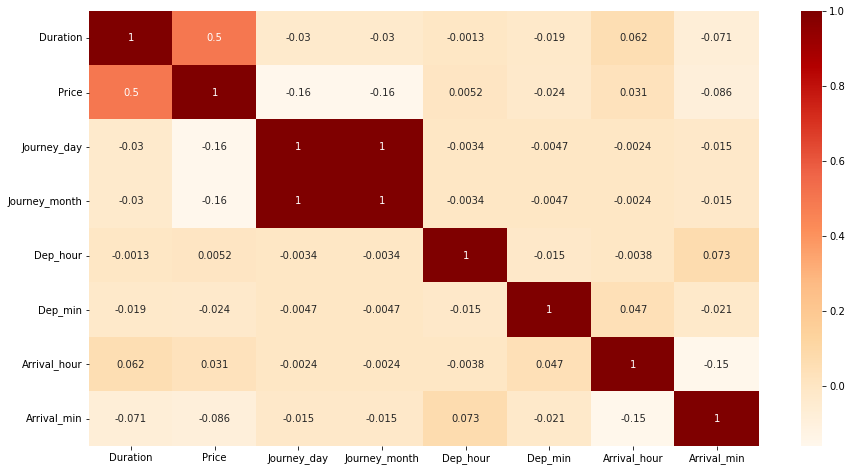

In [92]:
# Plotting correlation
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, cmap = 'OrRd');

In [93]:
# Split dataset in two parts: categorical and Numeric
data_categorical = data.select_dtypes(exclude=['int64', 'float', 'int32'])
data_numeric = data.select_dtypes(include=['int64', 'float', 'int32'])

In [94]:
data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Route            10462 non-null  object
 4   Total_Stops      10462 non-null  object
 5   Additional_Info  10462 non-null  object
dtypes: object(6)
memory usage: 830.2+ KB


In [95]:
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Duration       10462 non-null  int64  
 1   Price          10462 non-null  float64
 2   Journey_day    10462 non-null  int64  
 3   Journey_month  10462 non-null  int64  
 4   Dep_hour       10462 non-null  int64  
 5   Dep_min        10462 non-null  int64  
 6   Arrival_hour   10462 non-null  int64  
 7   Arrival_min    10462 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 993.6 KB


In [96]:
# tranform categoric variables in numeric
lb = LabelEncoder()
data_categorical = data_categorical.apply(lb.fit_transform)

In [97]:
data_categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,3,0,5,18,4,8
1,1,3,0,84,1,8
2,4,2,1,118,1,8
3,3,3,0,91,0,8
4,3,0,5,29,0,8


In [98]:
# Concatenating both variables categorical and numeric
X = pd.concat([data_categorical, data_numeric], axis=1)
X = X.drop(['Price'], axis=1)
X

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Duration,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,3,0,5,18,4,8,170,24,24,22,20,1,10
1,1,3,0,84,1,8,445,1,1,5,50,13,15
2,4,2,1,118,1,8,1140,9,9,9,25,4,25
3,3,3,0,91,0,8,325,12,12,18,5,23,30
4,3,0,5,29,0,8,285,1,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,64,4,8,150,9,9,19,55,22,25
10679,1,3,0,64,4,8,155,27,27,20,45,23,20
10680,4,0,2,18,4,8,180,27,27,8,20,11,20
10681,10,0,5,18,4,8,160,1,1,11,30,14,10


In [99]:
y = data['Price']
y

0         3897.0
1         7662.0
2        13882.0
3         6218.0
4        13302.0
          ...   
10678     4107.0
10679     4145.0
10680     7229.0
10681    12648.0
10682    11753.0
Name: Price, Length: 10462, dtype: float64

In [100]:
# Calculating mean absolute percentage error
def mean_absolute_error(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [101]:
# normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [103]:
X_train.shape, y_train.shape

((7323, 13), (7323,))

In [104]:
X_test.shape, y_test.shape

((3139, 13), (3139,))

In [109]:
# performing GridSearchCV on Decision Tree Regression
depth = list(range(1,21))
param_grid = dict(max_depth = depth)

# Hyperpameter list
tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
tree.fit(X_train, y_train)

# predicting train and test results
y_pred = tree.predict(X_train)
prediction = tree.predict(X_test)

# show the best parameter
tree.best_params_

{'max_depth': 11}

In [111]:
# checking accuracy train model
print('*******Test Results for Decision Tree Regressor********')
print("Root Mean Squared Error: ", sqrt(mse(y_train.values, y_pred)))
print("Mean absolute % error: ", round(mean_absolute_error(y_train.values, y_pred)))
print("R-Squared: ", r2_score(y_train.values, y_pred))

*******Test Results for Decision Tree Regressor********
Root Mean Squared Error:  1458.7840231587504
Mean absolute % error:  11
R-Squared:  0.8988353797986035


In [117]:
# checking accuracy train model
print('*******Test Results for Decision Tree Regressor********')
print("Root Mean Squared Error: ", sqrt(mse(y_test, prediction)))
print("Mean absolute % error: ", round(mean_absolute_error(y_test, prediction)))
print("R-Squared: ", r2_score(y_test, prediction))

*******Test Results for Decision Tree Regressor********
Root Mean Squared Error:  2317.2518868686925
Mean absolute % error:  14
R-Squared:  0.7581554867785638
